# [문자-단위 RNN으로 이름 생성](https://tutorials.pytorch.kr/intermediate/char_rnn_generation_tutorial.html)

In [1]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [2]:
DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"

# 1.데이터 준비

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [4]:
all_letters = string.ascii_letters + " .,;'-"
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-"

In [5]:
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가
n_letters

59

In [6]:
def findFiles(path): 
  return glob.glob(path)

In [7]:
file_list = findFiles(DATA_PATH+'names/*.txt')

print(f'len: {len(file_list)}') # 18개 국적 
file_list[:5]

len: 18


['/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/German.txt',
 '/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/Spanish.txt',
 '/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/Greek.txt',
 '/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/Chinese.txt',
 '/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/Portuguese.txt']

In [8]:
file_list[0]

'/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/German.txt'

In [9]:
category = os.path.splitext(os.path.basename(file_list[0]))[0]
category

'German'

In [10]:
# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [11]:
unicodeToAscii('à')

'a'

In [12]:
unicodeToAscii('é')

'e'

In [13]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [48]:
german_file = DATA_PATH+'names/German.txt'

german_list = readLines(german_file)

print(f'len: {len(german_list)}') # 이름들..
german_list[:5]

len: 724


['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']

In [49]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['German', 'Spanish', 'Greek', 'Chinese', 'Portuguese', 'Scottish', 'Korean', 'Vietnamese', 'English', 'Russian', 'French', 'Polish', 'Arabic', 'Irish', 'Dutch', 'Japanese', 'Czech', 'Italian']
O'Neal


# 2.네트워크 생성

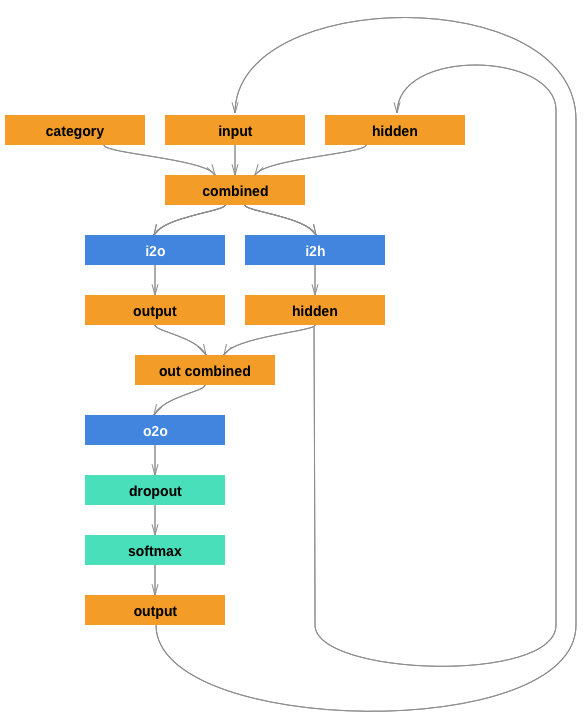

In [50]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 3.학습

## 학습 준비

In [51]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [52]:
all_categories[:3]

['German', 'Spanish', 'Greek']

In [53]:
randomChoice(all_categories)

'Arabic'

In [54]:
category_lines['Spanish'][:3]

['Abana', 'Abano', 'Abarca']

In [55]:
line = randomChoice(category_lines['Spanish'])
line

'Huerta'

In [56]:
# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [57]:
randomTrainingPair()

('Chinese', 'Cui')

각 단계 마다 네트워크의 입력은 `(언어, 현재 문자, 은닉 상태)`가 되고, 출력은 `(다음 문자, 다음 은닉 상태)`가 된다.   
  
언어(Category) Tensor는 `<1 x n_categories>` 크기의 One-hot Tensor입니다. 

In [58]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [59]:
categoryTensor('Spanish')

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [60]:
categoryTensor('Spanish').shape

torch.Size([1, 18])

In [61]:
# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [62]:
inputTensor('Uzky')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [63]:
inputTensor('Uzky').shape # (글자수, 1, len(all_letters))

torch.Size([4, 1, 59])

In [64]:
# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [65]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-"

In [66]:
line = 'U'

letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
letter_indexes # 두번째 문자가 없음....

[]

In [67]:
line = 'Uz'

letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
letter_indexes # 두번째 문자인 z의 인덱스 값임...

[25]

In [68]:
letter_indexes.append(n_letters - 1) # EOS
letter_indexes # EOS: 58

[25, 58]

In [69]:
targetTensor('Uzky') # z: 25, k:10, y:24, EOS: 58

tensor([25, 10, 24, 58])

학습 동안 무작위로 (category(언어), line(이름))을 가져오고 그것을 필요한 형태(category(언어), input(현재 문자), target(다음 문자)) tensor로 바꾸는 함수를 만듭니다.

In [70]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair() # 나라이름, 이름
    category_tensor = categoryTensor(category) # Category를 위한 One-hot 벡터 (1, 18)
    input_line_tensor = inputTensor(line) # (글자수, 1, len(all_letters))
    target_line_tensor = targetTensor(line) # (두번째 부터의 문자 인덱스 및 EOS)
    return category_tensor, input_line_tensor, target_line_tensor

In [71]:
category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()

In [72]:
category_tensor.shape, input_line_tensor.shape, target_line_tensor.shape

(torch.Size([1, 18]), torch.Size([7, 1, 59]), torch.Size([7]))

In [73]:
target_line_tensor.unsqueeze(-1).shape

torch.Size([7, 1])

## 네트워크 학습

In [74]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad() 

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

학습에 걸리는 시간을 추적하기 위한 함수 생성

In [75]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [43]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 17s (5000 5%) 3.0874
0m 33s (10000 10%) 2.3891
0m 50s (15000 15%) 2.7748
1m 7s (20000 20%) 2.2800
1m 23s (25000 25%) 2.1638
1m 39s (30000 30%) 2.7938
1m 55s (35000 35%) 2.5373
2m 11s (40000 40%) 3.5551
2m 27s (45000 45%) 2.6432
2m 43s (50000 50%) 2.6600
2m 59s (55000 55%) 2.4774
3m 15s (60000 60%) 2.6233
3m 31s (65000 65%) 2.1664
3m 47s (70000 70%) 2.2390
4m 3s (75000 75%) 2.1574
4m 18s (80000 80%) 3.0131
4m 34s (85000 85%) 2.9375
4m 50s (90000 90%) 3.3260
5m 6s (95000 95%) 1.6261
5m 22s (100000 100%) 2.8476


## 손실 도식화

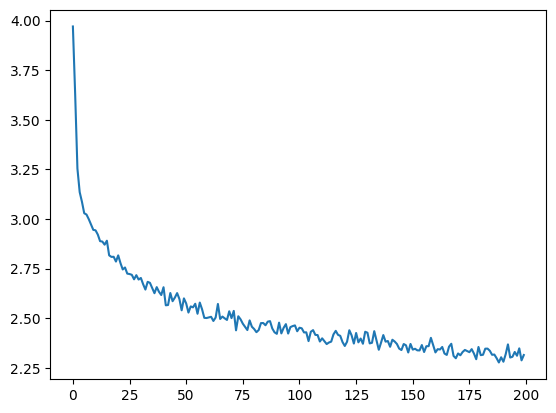

In [44]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# plt.figure()
plt.plot(all_losses)
plt.show()

# 4.네트워크 샘플링

In [45]:
# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A', max_length=20):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            top_values, top_indexs = output.topk(1)
            top_index = top_indexs[0][0]
            if top_index == n_letters - 1:
                break
            else:
                letter = all_letters[top_index]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [46]:
# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [47]:
samples('Russian', 'RUS')
print('-'*50)
samples('German', 'GER')
print('-'*50)
samples('Spanish', 'SPA')
print('-'*50)
samples('Chinese', 'CHI')

Roshill
Uantonov
Shakan
--------------------------------------------------
Gerterr
Erester
Rong
--------------------------------------------------
Salla
Para
Allan
--------------------------------------------------
Chan
Han
Iun
